# VCT

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [86]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
import sympy as sp
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs, remove_functions

from phd.visualization.bokeh_plotting import create_tab
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions
from sklearn.metrics import r2_score, mean_absolute_error
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]

import logging
log = logging.getLogger()
handler = log.handlers[0]
handler.setLevel(logging.ERROR)  # Remove info 

import matplotlib.pyplot as plt


import yaml
#plt.rcParams["figure.figsize"] = (12,7)

with open('styles.yml', 'r') as file:
    styles = yaml.safe_load(file)

from phd.pipelines.regression_VCT.nodes import df_VCT_to_prime

import seaborn as sns
import paper
from paper import save_fig, save_eq

In [6]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")
df_VCT = catalog.load(f"{ship}.df_VCT_scaled_limited")

In [61]:
model = catalog.load(f"{ship}.models_VCT")['semiempirical_covered']()

In [62]:
df_VCT['test type'].unique()


array(['Circle', 'Circle + Drift', 'Circle + rudder angle', 'Drift angle',
       'Rudder and drift angle', 'Rudder angle', 'Thrust variation',
       'self propulsion', 'Rudder angle resistance (no propeller)'],
      dtype=object)

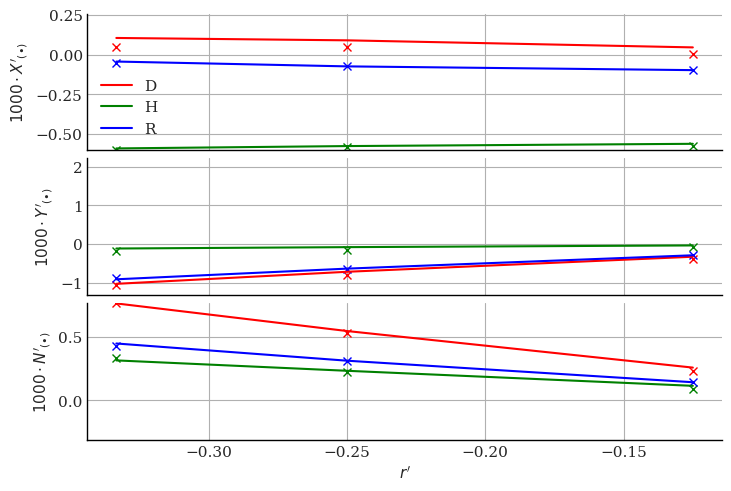

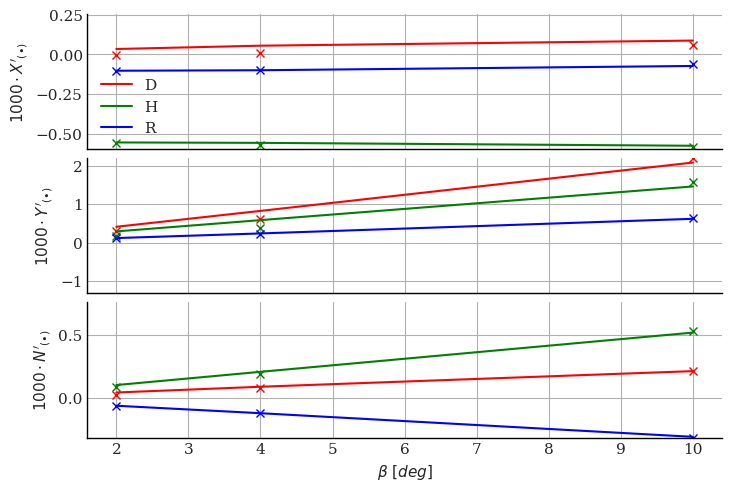

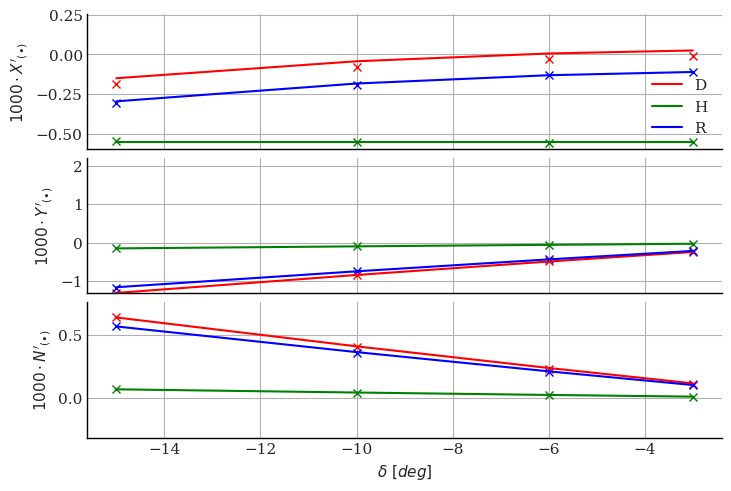

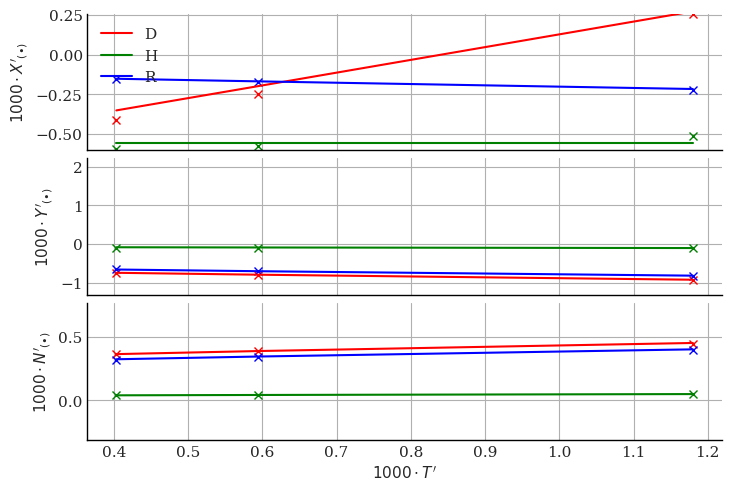

In [128]:
dofs = ['X','Y','N']
dof_labels = {
    'X':r"$1000 \cdot {X'}_{(\bullet)}$",
    'Y':r"$1000 \cdot {Y'}_{(\bullet)}$",
    'N':r"$1000 \cdot {N'}_{(\bullet)}$",
}
items = ['D','H','R']
xs = {
    'Circle':{'key':'r','label':r"$r'$"},
    'Drift angle':{'key':'beta_deg','label':r'$\beta$ $[deg]$'},
    'Rudder angle':{'key':'delta_deg','label':r'$\delta$ $[deg]$'},
    'Thrust variation':{'key':'1000T','label':r"$1000 \cdot T'$"},
    'self propulsion':{'key':'V','label':r'$V$ $[m/s]$'},
}

df_VCT_show = df_VCT.copy()
skip_test_types = [
    "Circle + Drift",
    'Circle + rudder angle',
    'Rudder and drift angle',
    'Rudder angle resistance (no propeller)',
    'self propulsion',
]
mask = df_VCT_show['test type'].isin(skip_test_types)
df_VCT_show=df_VCT_show.loc[~mask]

mask = ((df_VCT_show['test type'] == 'Thrust variation') & (df_VCT_show['V'] < 0.5))
df_VCT_show=df_VCT_show.loc[~mask]


df_VCT_predict = predict(model, data=df_VCT_show)
df_VCT_predict['model_name'] = "VCT regression"
df_VCT_predict['Y_H']+=df_VCT_predict['Y_RHI']
df_VCT_predict['N_H']+=df_VCT_predict['N_RHI']

df_VCT_show_prime = df_VCT_to_prime(model=model, df_VCT=df_VCT_show)
df_VCT_predict_prime = df_VCT_to_prime(model=model, df_VCT=df_VCT_predict)

def extra(df):
    df['beta_deg'] = np.rad2deg(df['beta'])
    df['delta_deg'] = np.rad2deg(df['delta'])
    df['1000T'] = 1000*df['thrust']
    for dof in dofs:
        for item in items:
               
            df[f"1000{dof}_{item}"] = 1000*df[f"{dof}_{item}"]

    

extra(df_VCT_show_prime)
extra(df_VCT_predict_prime)

prediction_groups = df_VCT_predict_prime.groupby(by='test type')

for test_type, group in df_VCT_show_prime.groupby(by='test type'):

    x = xs.get(test_type,{})
    x_key = x.get('key',None)
    x_label = x.get('label',None)

    if not x_key is None:
        group.sort_values(by=x_key, inplace=True)
    
    fig,axes=plt.subplots(nrows=len(dofs))
    for ax,dof in zip(axes,dofs):
               
        #ys = [column for column in group.columns if f"{dof}_" in column and not (("port" in column) or ("stbd" in column))]
        ys = [f"1000{dof}_{item}" for item in items]
        group.plot(x=x_key, y=ys,ax=ax, label=["_none_","_none_","_none_"], color=['r','g','b'],style='x')
        
        df_prediction = prediction_groups.get_group(test_type)
        if not x_key is None:
            df_prediction.sort_values(by=x_key, inplace=True)
        df_prediction.plot(x=x_key, y=ys,ax=ax, label=items, color=['r','g','b'], style='-')
        
        if not x_key is None and not x_label is None:
            ax.set_xlabel(x_label)
        ax.set_ylabel(dof_labels[dof])
        ax.grid(True)

        ax.set_ylim(df_VCT_show_prime[ys].min().min(),df_VCT_show_prime[ys].max().max())
    
    #axes[0].set_title(test_type)
    
    for ax in axes[1:]:
        ax.get_legend().set_visible(False)
        
    for ax in axes[0:-1]:
        ax.set_xticklabels([])
        ax.set_xlabel("")
 
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(paper.file_path_with_nb_ref(f"VCT {test_type}.svg"))
    